In [1]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pandas

  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 5.8 MB/s  0:00:01 eta 0:00:01
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pandas]2m2/3 [pandas]
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install opencv-python

  Using cached numpy-2.2.6-cp310-cp310-macosx_14_0_arm64.whl.metadata (62 kB)
Using cached numpy-2.2.6-cp310-cp310-macosx_14_0_arm64.whl (5.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.21 requires numpy<2, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install streamlit

  Using cached streamlit-1.48.0-py3-none-any.whl.metadata (9.5 kB)
  Using cached altair-5.5.0-py3-none-any.whl.metadata (11 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached cachetools-6.1.0-py3-none-any.whl.metadata (5.4 kB)
  Using cached click-8.2.1-py3-none-any.whl.metadata (2.5 kB)
  Using cached tenacity-9.1.2-py3-none-any.whl.metadata (1.2 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl.metadata (7.1 kB)
  Using cached gitpython-3.1.45-py3-none-any.whl.metadata (13 kB)
  Using cached pydeck-0.9.1-py2.py3-none-any.whl.metadata (4.1 kB)
  Using cached narwhals-2.0.1-py3-none-any.whl.metadata (11 kB)
  Using cached gitdb-4.0.12-py3-none-any.whl.metadata (1.2 kB)
  Using cached smmap-5.0.2-py3-none-any.whl.metadata (4.3 kB)
Using cached streamlit-1.48.0-py3-none-any.whl (9.9 MB)
Using cached altair-5.5.0-py3-none-any.whl (731 kB)
Using cached blinker-1.9.0-py3-none-any.whl (8.5 kB)
Using cached cachetools-6.1.0-py3-none-any.whl (11 kB)
Using cac

In [3]:
import os
import time
import logging
import warnings
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
from datetime import datetime
from collections import deque

In [4]:
# Suppress Keras PyDataset warning
warnings.filterwarnings('ignore', category=UserWarning)

In [5]:
# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('face_expression_detector.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

In [6]:
# Define constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_CLASSES = 7
EMOTION_LABELS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
DATASET_PATH = "/Users/nazmussakibsheam/GUB/Data-mining-lab/face_expression_detector/webcam_dataset"
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
TEST_PATH = os.path.join(DATASET_PATH, "test")
MODEL_PATH = 'facial_expression_model.keras'
EMOTION_HISTORY_PATH = 'emotion_history.csv'
IMAGES_PER_EMOTION = 10
TRAIN_SPLIT = 0.8
EMOTION_EMOJIS = {
    'Angry': '😣', 'Disgust': '🤢', 'Fear': '😨', 'Happy': '😊',
    'Sad': '😢', 'Surprise': '😮', 'Neutral': '😐'
}
TREND_WINDOW = 50  # Number of recent predictions for trend graph

In [7]:
def create_dataset_dirs(dataset_path):
    """Create directory structure for train and test sets."""
    for split in ['train', 'test']:
        split_path = os.path.join(dataset_path, split)
        os.makedirs(split_path, exist_ok=True)
        for emotion in EMOTION_LABELS:
            os.makedirs(os.path.join(split_path, emotion), exist_ok=True)
    logger.info(f"Created dataset directories at {dataset_path}")

In [8]:
def capture_training_data(dataset_path):
    """Capture 10 images per emotion from webcam with 1-second delay."""
    create_dataset_dirs(dataset_path)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    if face_cascade.empty():
        logger.error("Failed to load Haar Cascade classifier")
        raise ValueError("Failed to load Haar Cascade classifier")

    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        logger.error("Failed to open webcam")
        raise ValueError("Failed to open webcam")

    logger.info(f"Starting webcam to capture {IMAGES_PER_EMOTION} images per emotion.")
    logger.info("Wait until 10 images are captured per emotion. Press 'q' only when prompted.")

    for emotion in EMOTION_LABELS:
        logger.info(f"Capturing images for: {emotion}")
        count = 0
        train_count = 0
        test_count = 0
        while count < IMAGES_PER_EMOTION:
            ret, frame = cap.read()
            if not ret:
                logger.error("Failed to capture frame from webcam")
                break

            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.05, minNeighbors=3, minSize=(30, 30))

            for (x, y, w, h) in faces:
                face = gray[y:y+h, x:x+w]
                face = cv2.resize(face, IMG_SIZE)
                face_rgb = cv2.cvtColor(face, cv2.COLOR_GRAY2RGB)
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                cv2.putText(frame, f"{emotion} ({count}/{IMAGES_PER_EMOTION})", (x, y-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
                cv2.putText(frame, f"Avatar: {EMOTION_EMOJIS[emotion]}", (10, 30),
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

                split = 'train' if count < int(IMAGES_PER_EMOTION * TRAIN_SPLIT) else 'test'
                save_path = os.path.join(dataset_path, split, emotion, f"{emotion}_{count}.jpg")
                cv2.imwrite(save_path, face_rgb)
                logger.info(f"Saved {save_path}")
                count += 1
                if split == 'train':
                    train_count += 1
                else:
                    test_count += 1
                time.sleep(1)
                break

            cv2.imshow(f'Capture {emotion}', frame)
            if count >= IMAGES_PER_EMOTION:
                logger.info(f"Captured {train_count} train and {test_count} test images for {emotion}. Press 'q' to continue.")
                while True:
                    if cv2.waitKey(1) & 0xFF == ord('q'):
                        break
            elif cv2.waitKey(1) & 0xFF == ord('q'):
                logger.warning(f"Only captured {count} images for {emotion}. Continue anyway? (y/n)")
                if input().lower() != 'y':
                    logger.error(f"Aborted capture for {emotion}. Please recapture all emotions.")
                    cap.release()
                    cv2.destroyAllWindows()
                    raise ValueError(f"Incomplete capture for {emotion}")

        if emotion == EMOTION_LABELS[-1] and count >= IMAGES_PER_EMOTION:
            logger.info("Finished capturing for all emotions.")
            break

    cap.release()
    cv2.destroyAllWindows()

In [9]:

def validate_directory(path, require_images=True):
    """Check if directory contains images for all emotions."""
    if not os.path.exists(path):
        if require_images:
            logger.error(f"Directory {path} does not exist")
            raise ValueError(f"Directory {path} does not exist")
        return False
    for emotion in EMOTION_LABELS:
        emotion_path = os.path.join(path, emotion)
        if not os.path.exists(emotion_path) or (require_images and not os.listdir(emotion_path)):
            if require_images:
                logger.error(f"No images found in {emotion_path}")
                raise ValueError(f"No images found in {emotion_path}")
            return False
    logger.info(f"Validated directory {path}")
    return True

In [10]:
def load_data(train_path, test_path):
    """Load and preprocess data using ImageDataGenerator."""
    validate_directory(train_path, require_images=True)
    has_test_data = validate_directory(test_path, require_images=False)

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.2,
        brightness_range=[0.8, 1.2],
        horizontal_flip=True,
        validation_split=0.2
    )
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=IMG_SIZE,
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        classes=EMOTION_LABELS,
        subset='training'
    )
    val_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=IMG_SIZE,
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        classes=EMOTION_LABELS,
        subset='validation'
    )
    test_generator = None
    if has_test_data:
        test_generator = test_datagen.flow_from_directory(
            test_path,
            target_size=IMG_SIZE,
            color_mode='rgb',
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            classes=EMOTION_LABELS
        )
    return train_generator, val_generator, test_generator

In [11]:
def build_model():
    """Build MobileNetV2-based model for emotion classification."""
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    logger.info("Built MobileNetV2 model")
    return model

In [12]:
def train_model(model, train_generator, val_generator):
    """Train the model with early stopping and learning rate reduction."""
    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
        ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor='val_loss'),
        ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)
    ]
    history = model.fit(
        train_generator,
        epochs=30,
        validation_data=val_generator,
        callbacks=callbacks
    )
    logger.info("Model training completed")
    return history

In [13]:
def evaluate_model(model, val_generator, test_generator):
    """Evaluate model on validation and test sets."""
    val_loss, val_accuracy = model.evaluate(val_generator)
    logger.info(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    if test_generator:
        test_loss, test_accuracy = model.evaluate(test_generator)
        logger.info(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    else:
        logger.warning("No test data available for evaluation")

In [14]:
def plot_confusion_matrix(model, val_generator):
    """Plot confusion matrix for validation set."""
    y_pred = []
    y_true = []
    for images, labels in val_generator:
        preds = model.predict(images, verbose=0)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(np.argmax(labels, axis=1))
        if len(y_pred) >= val_generator.samples:
            break
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=EMOTION_LABELS, yticklabels=EMOTION_LABELS)
    plt.title('Confusion Matrix (Validation Set)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('confusion_matrix.png')
    plt.show()
    logger.info("Generated and saved confusion matrix")

In [15]:
def plot_history(history):
    """Plot and save training and validation accuracy/loss."""
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='#1f77b4')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='#ff7f0e')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='#1f77b4')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='#ff7f0e')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('training_history.png')
    plt.show()
    logger.info("Plotted and saved training history")


In [16]:
def plot_trend_graph(frame, trend_data, width, height):
    """Draw a real-time emotion trend graph on the frame."""
    graph_height = 100
    graph_width = 200
    graph_x, graph_y = width - graph_width - 10, height - graph_height - 10
    cv2.rectangle(frame, (graph_x, graph_y), (graph_x + graph_width, graph_y + graph_height), (255, 255, 255), -1)
    cv2.rectangle(frame, (graph_x, graph_y), (graph_x + graph_width, graph_y + graph_height), (0, 0, 0), 1)

    if len(trend_data) > 1:
        max_points = min(len(trend_data), graph_width // 2)
        step = graph_width / max_points
        emotion_counts = [EMOTION_LABELS.index(emo) for emo in list(trend_data)[-max_points:]]
        for i in range(len(emotion_counts) - 1):
            x1 = int(graph_x + i * step)
            x2 = int(graph_x + (i + 1) * step)
            y1 = int(graph_y + graph_height - (emotion_counts[i] / NUM_CLASSES) * graph_height)
            y2 = int(graph_y + graph_height - (emotion_counts[i + 1] / NUM_CLASSES) * graph_height)
            cv2.line(frame, (x1, y1), (x2, y2), (0, 0, 255), 1)


In [17]:
def process_webcam(model, save_video=False):
    """Process webcam feed with emotion detection, intensity bar, and trend graph."""
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    if face_cascade.empty():
        logger.error("Failed to load Haar Cascade classifier")
        raise ValueError("Failed to load Haar Cascade classifier")

    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        logger.error("Failed to open webcam")
        raise ValueError("Failed to open webcam")

    if save_video:
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter('output.avi', fourcc, 20.0, (640, 480))
        logger.info("Recording video to output.avi")

    emotion_history = []
    trend_data = deque(maxlen=TREND_WINDOW)
    ret, frame = cap.read()
    if ret:
        height, width = frame.shape[:2]
    else:
        height, width = 480, 640

    while True:
        ret, frame = cap.read()
        if not ret:
            logger.error("Failed to capture frame from webcam")
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.05, minNeighbors=3, minSize=(30, 30))

        for (x, y, w, h) in faces:
            face = gray[y:y+h, x:x+w]
            face = cv2.resize(face, IMG_SIZE)
            face_rgb = cv2.cvtColor(face, cv2.COLOR_GRAY2RGB)
            face_rgb = face_rgb.astype('float32') / 255.0
            face_rgb = np.expand_dims(face_rgb, axis=0)

            prediction = model.predict(face_rgb, verbose=0)[0]
            emotion = EMOTION_LABELS[np.argmax(prediction)]
            emotion_history.append((datetime.now(), emotion, prediction.tolist()))
            trend_data.append(emotion)

            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(frame, f"{emotion} {EMOTION_EMOJIS[emotion]}", (x, y-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
            cv2.putText(frame, f"Avatar: {EMOTION_EMOJIS[emotion]}", (10, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

            # Draw intensity bar
            bar_width = 100
            bar_height = 10
            y_offset = 50
            for i, (emo, prob) in enumerate(zip(EMOTION_LABELS, prediction)):
                width = int(prob * bar_width)
                cv2.rectangle(frame, (10, y_offset + i*15), (10 + width, y_offset + i*15 + bar_height),
                             (0, 255, 255), -1)
                cv2.putText(frame, f"{emo}: {prob:.2f}", (120, y_offset + i*15 + 10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

        # Draw trend graph
        plot_trend_graph(frame, trend_data, width, height)

        cv2.imshow('Facial Expression Recognition', frame)
        if save_video:
            out.write(frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    if save_video:
        out.release()
    cv2.destroyAllWindows()
    logger.info("Stopped webcam feed")

    # Save emotion history
    df = pd.DataFrame(emotion_history, columns=['Timestamp', 'Emotion', 'Probabilities'])
    df.to_csv(EMOTION_HISTORY_PATH, index=False)
    logger.info(f"Saved emotion history to {EMOTION_HISTORY_PATH}")
    return emotion_history

2025-08-09 20:50:55,453 - INFO - Starting Facial Expression Recognition project


Capture training data first? (y/n)


 n


2025-08-09 20:50:59,099 - INFO - Validated directory /Users/nazmussakibsheam/GUB/Data-mining-lab/face_expression_detector/webcam_dataset/train
2025-08-09 20:50:59,099 - INFO - Validated directory /Users/nazmussakibsheam/GUB/Data-mining-lab/face_expression_detector/webcam_dataset/test


Found 49 images belonging to 7 classes.
Found 7 images belonging to 7 classes.
Found 14 images belonging to 7 classes.


2025-08-09 20:50:59,400 - INFO - Built MobileNetV2 model


Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.1797 - loss: 2.6937 - val_accuracy: 0.0000e+00 - val_loss: 2.3225 - learning_rate: 0.0010
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.1605 - loss: 2.5265 - val_accuracy: 0.0000e+00 - val_loss: 2.0165 - learning_rate: 0.0010
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.2547 - loss: 2.2787 - val_accuracy: 0.1429 - val_loss: 2.0055 - learning_rate: 0.0010
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1908 - loss: 1.9949 - val_accuracy: 0.1429 - val_loss: 2.0374 - learning_rate: 0.0010
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.2216 - loss: 1.9540 - val_accuracy: 0.0000e+00 - val_loss: 2.0471 - learning_rate: 0.0010
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.2832 - loss: 1.8307 - val_accuracy: 0.1429 - val_loss: 1.9481 - learning_rate: 0.0010
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.2517 - loss: 1.9438 - val_

2025-08-09 20:51:06,360 - INFO - Model training completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.2857 - loss: 1.7915


2025-08-09 20:51:06,465 - INFO - Validation Loss: 1.7915, Validation Accuracy: 0.2857


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.0714 - loss: 2.3206


2025-08-09 20:51:06,580 - INFO - Test Loss: 2.3206, Test Accuracy: 0.0714


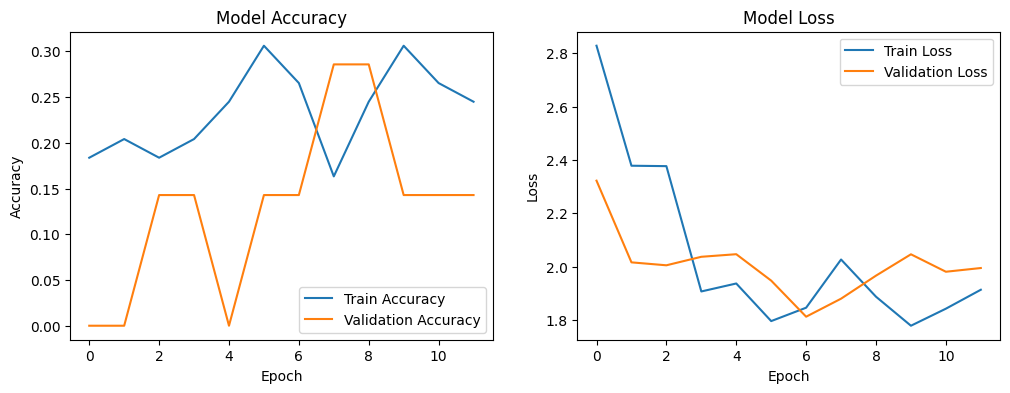

2025-08-09 20:51:06,698 - INFO - Plotted and saved training history


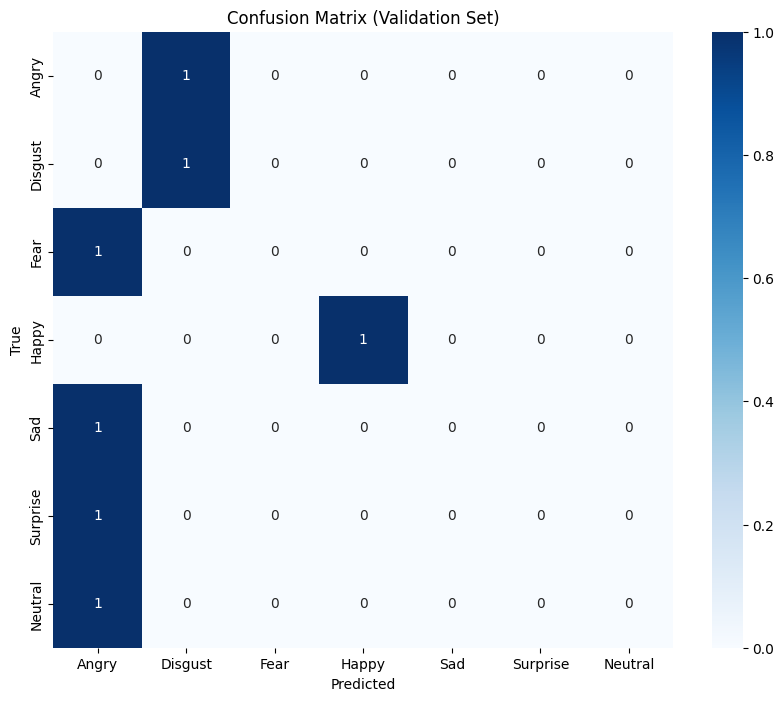

2025-08-09 20:51:07,193 - INFO - Generated and saved confusion matrix
2025-08-09 20:51:07,193 - INFO - Starting webcam feed for emotion detection. Press 'q' to quit.


Save video output? (y/n)


 n


2025-08-09 20:54:26,033 - INFO - Stopped webcam feed
2025-08-09 20:54:26,060 - INFO - Saved emotion history to emotion_history.csv
2025-08-09 20:54:26,062 - INFO - Run 'streamlit run dashboard.py' to view the emotion dashboard.


Run 'streamlit run dashboard.py' to view the emotion dashboard at http://localhost:8501


In [18]:
def main():
    """Main function to orchestrate data capture, training, and prediction."""
    logger.info("Starting Facial Expression Recognition project")

    # Capture webcam data
    print("Capture training data first? (y/n)")
    if input().lower() == 'y':
        try:
            capture_training_data(DATASET_PATH)
        except ValueError as e:
            logger.error(f"Capture failed: {e}")
            return

    # Load data
    try:
        train_generator, val_generator, test_generator = load_data(TRAIN_PATH, TEST_PATH)
    except ValueError as e:
        logger.error(f"Data loading failed: {e}")
        return

    # Build and train model
    model = build_model()
    history = train_model(model, train_generator, val_generator)

    # Evaluate model
    evaluate_model(model, val_generator, test_generator)

    # Plot results
    plot_history(history)
    plot_confusion_matrix(model, val_generator)

    # Process live webcam feed
    logger.info("Starting webcam feed for emotion detection. Press 'q' to quit.")
    print("Save video output? (y/n)")
    save_video = input().lower() == 'y'
    try:
        emotion_history = process_webcam(model, save_video)
    except ValueError as e:
        logger.error(f"Webcam processing failed: {e}")
        return

    logger.info("Run 'streamlit run dashboard.py' to view the emotion dashboard.")
    print("Run 'streamlit run dashboard.py' to view the emotion dashboard at http://localhost:8501")

if __name__ == "__main__":
    main()

In [ ]:
!streamlit run dashboard.py